In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pickle
import geopandas as gpd
import rioxarray as rio
import matplotlib.ticker as mticker
import calendar
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import mapping
from mhm_dataprocessing import *

#font segoe ui
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'


#### Flow validation

In [ ]:
src_dir = r"W:/VUB/_main_research/mHM/flow_data/waterinfo_csv/waterinfo_timeseries/"
station_locations = pd.read_csv(src_dir + "mhm_flow_stations_coordinates.csv")
sim_flow_mhm = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mRM_Fluxes_States.nc")
mhm_fluxes = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_Fluxes_States.nc")
#Gleam root zone soil moisture
gleam_rzsm = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\gleam_EUR_SMrz_EAS_2000_2023.nc")

#shapefile study area
be_shp = gpd.read_file(r"W:\VUB\_main_research\mHM\mhm_belgium\be_shp\be.shp")

In [43]:
#resample fluxes to month ends
variables = ['SM_L01','SM_L02','SM_L03','SWC_L01','SWC_L02','SWC_L03','recharge']

mhm_fluxes_mon= mhm_fluxes[variables].resample(time='ME').mean()

#### Simulated data

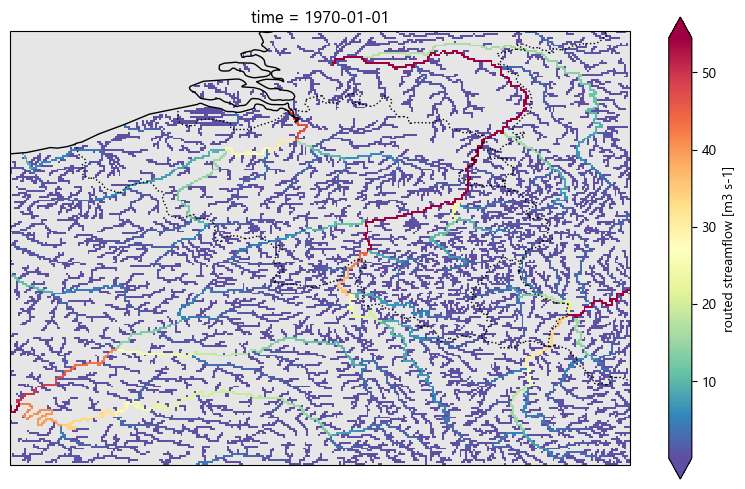

In [10]:
#sim_flow_mhm_calib['Qrouted'][0].plot(cmap='Spectral_r',robust=True)

# Assuming sim_flow_mhm_calib['Qrouted'][0] is your data array and it's correctly set up with coordinates
# Plot data where Qrouted is greater than 20
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
flow_data = sim_flow_mhm['Qrouted'][0].where(sim_flow_mhm['Qrouted'][0] > 0.05)
flow_data.plot(ax=ax, cmap='Spectral_r', robust=True, transform=ccrs.PlateCarree())

# Add a background map
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')
ax.add_feature(cartopy.feature.OCEAN, facecolor='0.9')
#ax.add_feature(cartopy.feature.LAKES, facecolor='0.9')
#ax.add_feature(cartopy.feature.RIVERS, edgecolor='blue')  # Changed to make rivers more visible
plt.show()

### Extract multistation data

In [3]:
#extracting the simulated flow
eval_station = {}

for station, row in station_locations.iterrows():
    station = row.stat_name
    mhm_flow = sim_flow_mhm['Qrouted'].sel(lat = row.lat, lon = row.lon, method = 'nearest') 
    sim_flow = mhm_flow.to_dataframe().drop(columns=['lat', 'lon'])

    observed = pd.read_csv(src_dir + f"{station}_Q.csv", parse_dates=True, index_col=0, dayfirst=True)
    observed[observed == -9999] = np.nan

    #fill blanks in observed data with nan
    observed = observed.resample('D').mean()

    obs_sim = pd.concat([observed, sim_flow], axis=1)
    obs_sim.columns = ['observed', 'simulated']
    obs_sim.dropna(inplace=True)
    obs_sim = obs_sim.resample('D').mean()

    eval_station[station] = obs_sim


### Goodness of Fit

In [37]:
def nse(observed, simulated):
    return np.round(1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2)),2)
def pbias(observed, simulated):
    return 100* np.round(np.sum(observed - simulated) / np.sum(observed),3)
def kge(observed, simulated):
    return np.round(1 - np.sqrt((np.corrcoef(observed, simulated)[0, 1] - 1) ** 2 + (np.std(simulated, ddof=1) / np.std(observed, ddof=1) - 1) ** 2 + (np.mean(simulated) / np.mean(observed) - 1) ** 2),2)

In [35]:
kge_values = {}
nse_values = {}
pbias_values = {}

for station, data in eval_station.items():
    kge_values[station] = kge(data['observed'], data['simulated'])
    nse_values[station] = nse(data['observed'], data['simulated'])
    pbias_values[station] = pbias(data['observed'], data['simulated'])

In [38]:
100* np.sum(eval_station['Maas']['observed'] - eval_station['Maas']['simulated'])/ np.sum(eval_station['Maas']['observed'])

7.128313932822438

In [39]:
nse_values

{'Maas': 0.8,
 'Helkijn': 0.65,
 'Gavere': 0.56,
 'Aarschot': 0.73,
 'Menen-Ropswalle': 0.57,
 'Overboelare': 0.53,
 'Eppebodegem': 0.47,
 'Geel': 0.11}

In [41]:
pbias_values = pd.Series(pbias_values)
pbias_values

Maas                7.0
Helkijn             8.0
Gavere              3.0
Aarschot           -1.0
Menen-Ropswalle    30.0
Overboelare        26.0
Eppebodegem        33.0
Geel               33.0
dtype: float64

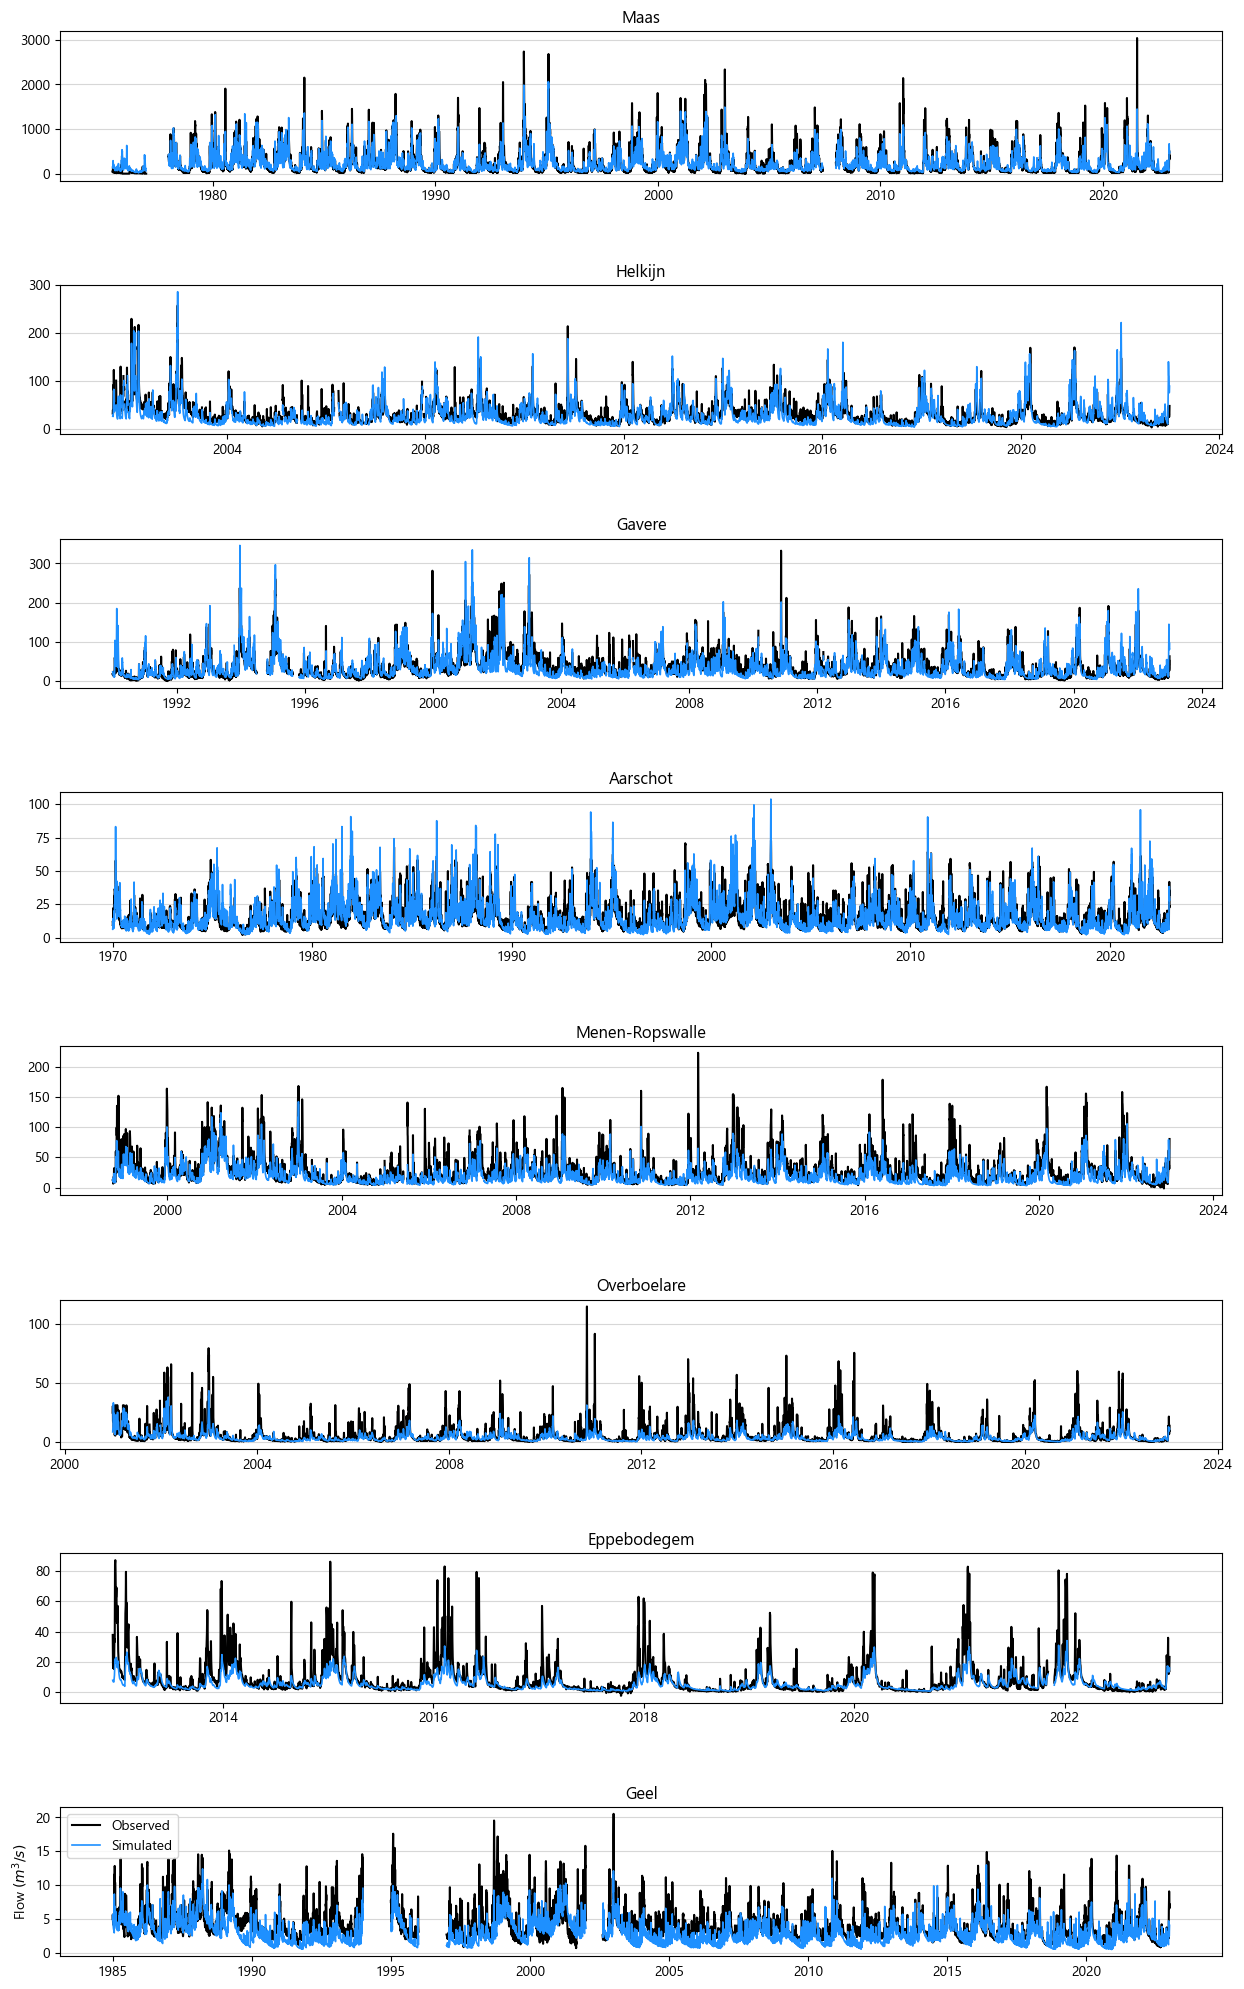

In [12]:
ncols = 1
nrows = len(eval_station)//ncols

fig, _ = plt.subplots(nrows, ncols, figsize=(15, 25))

#space between subplots
plt.subplots_adjust(hspace=0.7)

for stat in eval_station.keys():
    obs_sim = eval_station[stat]
    ax = plt.subplot(nrows, ncols, list(eval_station.keys()).index(stat)+1)
    ax.plot(obs_sim.index, obs_sim['observed'], label='Observed', color='black')
    ax.plot(obs_sim.index, obs_sim['simulated'], label='Simulated', color='dodgerblue', lw=1.2)
    ax.grid(alpha=0.5, axis='y')
    ax.set_title(stat)
plt.legend(loc='best')
plt.ylabel('Flow $(m^{3}/s)$');

### Spatial Datasets

#### Soil Moisture

In [44]:
#Define ROI
roi = dict(lat=slice(51.5, 50.0), lon=slice(2.0, 3.5))

#extracting the simulated flow
mhm_sm_ts = mhm_fluxes_mon['SM_L02'].sel(roi).mean(dim=['lat','lon']).to_dataframe()
gleam_sm_ts = gleam_rzsm['SMrz'].sel(roi).mean(dim=['lat','lon']).to_dataframe()

In [45]:
gleam_sm_ts.index.max(), mhm_sm_ts.index.max()

(Timestamp('2023-12-31 00:00:00'), Timestamp('2022-12-31 00:00:00'))

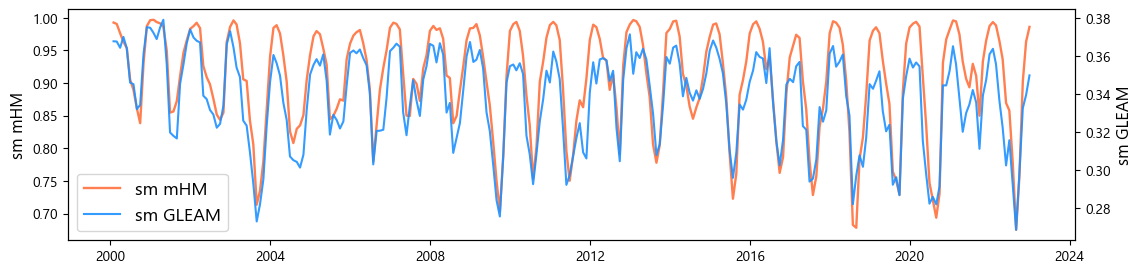

In [46]:
fig, ax = plt.subplots(figsize=(13, 3.0))
ax2=ax.twinx()
#mhm soil moisture
ax.plot(mhm_sm_ts['SM_L02'][gleam_sm_ts.index.min():mhm_sm_ts.index.max()], c='coral', lw=1.7, label='sm mHM')
ax2.plot(gleam_sm_ts[gleam_sm_ts.index.min():mhm_sm_ts.index.max()], c='dodgerblue', lw=1.5, label='sm GLEAM', alpha=0.9)
ax.set_ylabel('sm mHM', fontsize=12)
ax2.set_ylabel('sm GLEAM', fontsize=12)
plt.xticks(fontsize=15)
#collect legend handles and labels
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles + handles2, labels + labels2, fontsize=13)


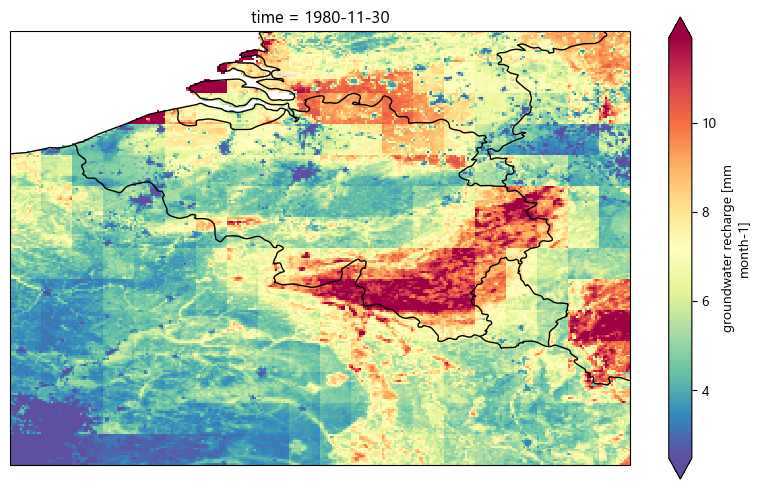

In [58]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
sm_data = mhm_fluxes['recharge'][130]
#values of soil moisture greater than 0.7
#sm_data = sm_data.where(sm_data > 0.7)


sm_data.plot(ax=ax, cmap='Spectral_r',robust='True', transform=ccrs.PlateCarree())

# Add a background map
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')

In [ ]:
#resample to month ends
mhm_monthly_recharge = mhm_fluxes['recharge'].resample(time='ME').sum()
mhm_mon_average_recharge = mhm_monthly_recharge.groupby('time.month').mean(dim='time')
mhm_annual_recharge = mhm_monthly_recharge.groupby('time.year').sum()

In [119]:
mhm_mean_month = mhm_fluxes.groupby('time.month').mean(dim='time')

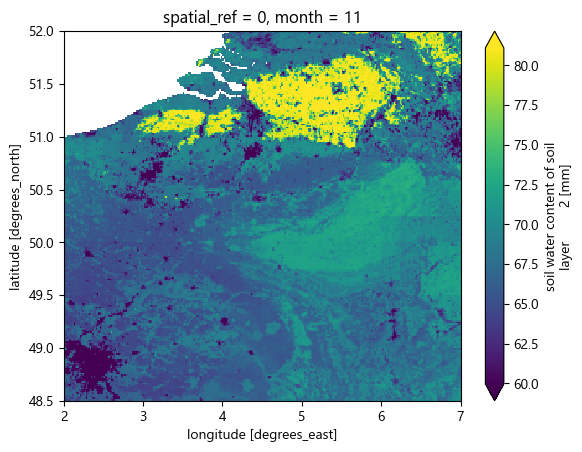

In [128]:
mhm_mean_month['SWC_L02'][10].plot(robust=True)

### Clip to Belgium

In [154]:
#import rioxarray
#ref: https://gis.stackexchange.com/questions/289775/masking-netcdf-data-using-shapefile-xarray-geopandas
#ref: https://medium.com/@harismushtaq021/clip-netcdf-data-from-shapefile-using-rioxarray-and-geopandas-5e5e5337fdd

data_be = clip_to_region(be_shp, mhm_fluxes)

data_be_monthly = data_be.groupby('time.month').mean(dim='time')

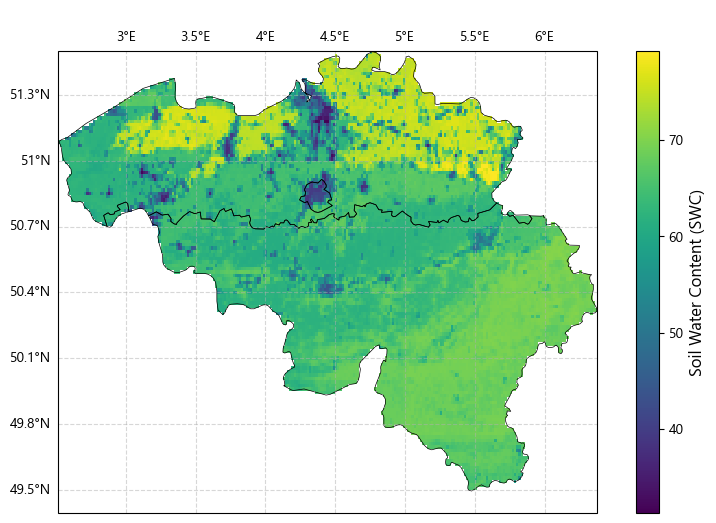

In [219]:
#plotting the clipped data
#change ccrs.PlateCarree() to ccrs.epsg(4326) for better resolution
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming `clipped`, `be_shp`, and other variables are already defined
layer = 'SWC_L02'

cmap = plt.get_cmap('viridis')

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
vmin, vmax = data_be[layer][140].min(), data_be[layer][140].max()

# Plot the data
im = data_be[layer][140].plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False  # Disable the default colorbar
)

# Add shapefile boundaries
be_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

# Add a horizontal colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05, aspect=20, shrink=1.0)
cbar.set_label('Soil Water Content (SWC)', fontsize=12)  # Add a label to the colorbar

# Add latitude and longitude gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', alpha=0.5, draw_labels=True)
gl.top_labels = True
gl.right_labels = False
gl.bottom_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.title(" ")
plt.show()


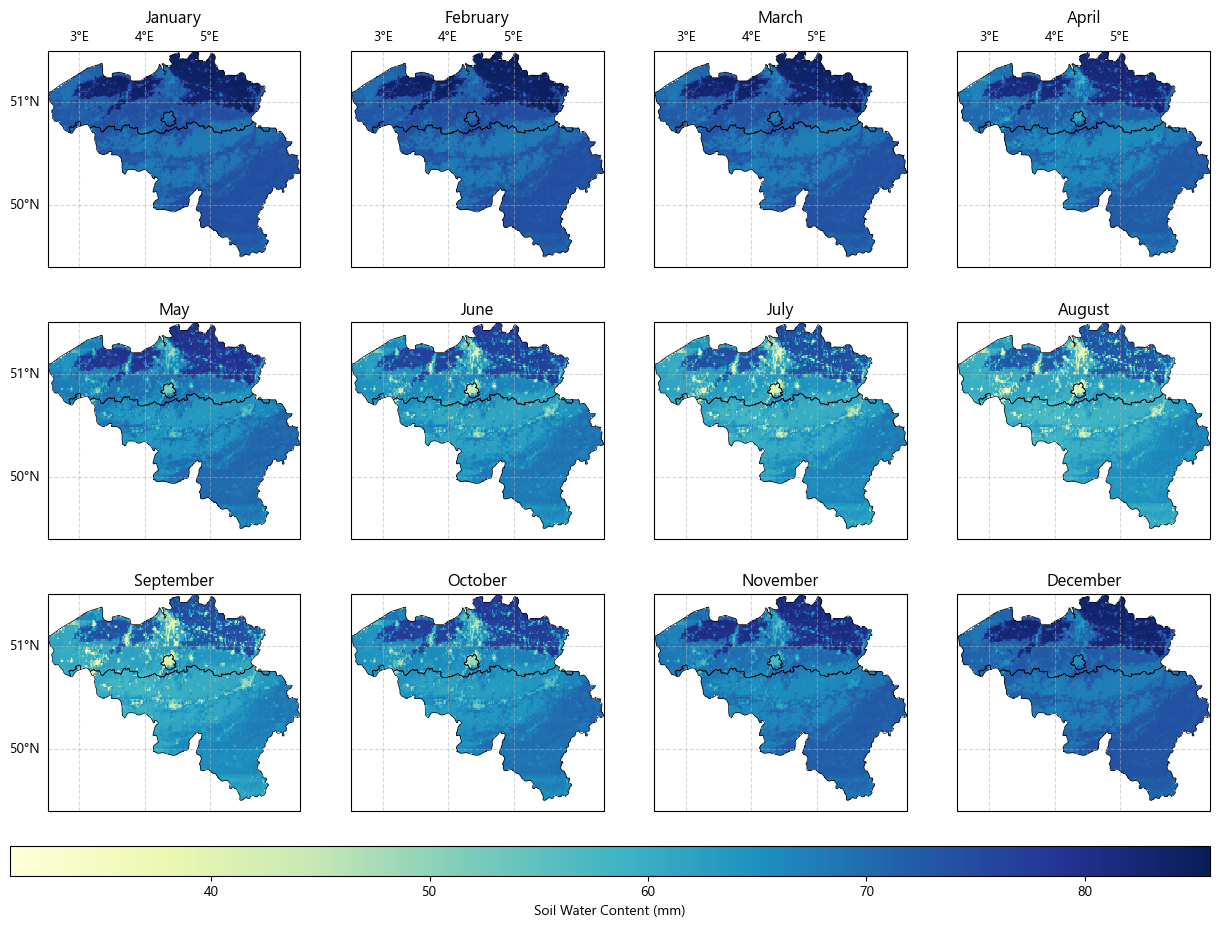

In [263]:
# Define grid dimensions
nrows = 3
ncols = len(mhm_mean_month.month) // nrows # Dynamic column calculation

fig, axes = plt.subplots(nrows, ncols, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(15, 10))
# Flatten axes for easier indexing
axes = axes.ravel()

    # Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.2)

# Calculate uniform vmin and vmax
vmin = data_be_monthly['SWC_L02'].min().values  # Minimum value across all months
vmax = data_be_monthly['SWC_L02'].max().values  # Maximum value across all months

# Plot each month's data
for idx, month in enumerate(mhm_mean_month.month):
    ax = axes[idx]
    im = data_be_monthly['SWC_L02'][month-1].plot(
        ax=ax,
        vmin=vmin,  # Set the minimum value
        vmax=vmax,  # Set the maximum value
        cmap='YlGnBu',  # Set the colormap
        #transform=ccrs.PlateCarree(),
        # robust=True,
        add_colorbar=False,
    )

    month_name = calendar.month_name[month.values]  # Get the name of the month
    ax.set_title(month_name, fontsize=12)

    # Add shapefile boundaries
    be_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

# Add latitude and longitude gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', alpha=0.5, draw_labels=True)
    # Show top labels only on the first row
    gl.top_labels = idx < ncols
    gl.bottom_labels = False

    # Show left labels only on the first column
    gl.left_labels = idx % ncols == 0
    gl.right_labels = False

    # Style grid labels
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    #label spacing
    # Style grid labels with spacing adjustments
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    #set xtick labels
    gl.xlocator = mticker.FixedLocator([2, 3, 4, 5])
    gl.ylocator = mticker.FixedLocator([50, 51, 52])



# Remove unused subplots if there are more axes than months
for ax in axes[len(mhm_mean_month.month):]:
    ax.remove()

# Add a shared colorbar
cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.03])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Soil Water Content (mm)')

plt.show()

In [262]:
month_name = calendar.month_name[month.values]

In [261]:
month_name

'December'